<a href="https://colab.research.google.com/github/JiaWeiXie/ntub_ai_bi/blob/main/ntub_bi_20220531.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
! pip install yfinance backtrader rich

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [83]:
import os
import sys
import math
import datetime

import backtrader as bt
import backtrader.feeds as btfeeds
import backtrader.analyzers as btanalyzers

from rich import print

In [84]:
import yfinance as yf

spy = yf.Ticker("SPY")
dataset = spy.history(period="max")
# dataset.to_csv("spy_max.csv")
dataset["2019"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-01-02,233.141423,238.098462,233.112990,237.122208,126925200,0.0,0
2019-01-03,235.273993,235.596258,230.951998,231.463821,144140700,0.0,0
2019-01-04,234.667399,239.899295,234.269322,239.216873,142628800,0.0,0
2019-01-07,239.501232,242.591076,238.553425,241.103027,103139100,0.0,0
2019-01-08,243.415694,243.880110,240.742872,243.368286,102512600,0.0,0
...,...,...,...,...,...,...,...
2019-12-24,310.460959,310.509234,309.910472,310.229187,20270000,0.0,0
2019-12-26,310.634754,311.890252,310.625116,311.880585,30911200,0.0,0
2019-12-27,312.653182,312.711125,311.243190,311.803314,42528800,0.0,0


In [85]:
class AllIn(bt.Sizer):
    def _getsizing(self, comminfo, cash, data, isbuy):
        price = data.open[1]
        position = self.broker.getposition(data)
        if isbuy:
            size = cash / price
        else:
            size = position.size

        return size

In [86]:
class StochRSI(bt.Indicator):
    """
    隨機相對強弱指數 Stochastic RSI
    Stoch RSI = (Current RSI - Lowest RSI)/(Highest RSI - Lowest RSI)
    """
    lines = ('stochrsi',)
    params = dict(
        period=14,  # to apply to RSI
        pperiod=None,  # if passed apply to HighestN/LowestN, else "period"
    )

    def __init__(self):
        # Current RSI
        rsi = bt.ind.RSI(self.data, period=self.p.period)

        pperiod = self.p.pperiod or self.p.period
        # Highest RSI
        maxrsi = bt.ind.Highest(rsi, period=pperiod)
        # Lowest RSI
        minrsi = bt.ind.Lowest(rsi, period=pperiod)

        # Stoch RSI = (Current RSI - Lowest RSI)/(Highest RSI - Lowest RSI)
        self.l.stochrsi = (rsi - minrsi) / (maxrsi - minrsi)

In [87]:
class StochRSIStrategy(bt.Strategy):
    def log(self, txt, dt=None):
        if not self.p.printlog:
            return

        dt = dt or self.datas[0].datetime.date(0)
        print(f"{dt}: {txt}")
    
    params = dict(
        over_bought=0.8,
        over_sold=0.2,
        period=14,
        printlog=True,
    )

    def __init__(self):
        self.stochrsi = StochRSI(self.datas[0], period=self.p.period)

        self.dataopen = self.datas[0].open

    def _log_tx(self, idx, price, txdate=None, isbuy=False):
        txdate = txdate if txdate else self.datas[0].datetime.date(0)
        if isbuy:
            self.log(
                f"[bold green]buy[/], {idx:.2f}, ${price:.2f}",
                txdate,
            )
        else:
            self.log(
                f"[bold red]sell[/], {idx:.2f}, ${price:.2f}",
                txdate,
            )


    def next(self):
        if len(self.data) == self.data.buflen():
            if self.position:
                self.close(price=self.dataopen[0])
                self._log_tx(self.stochrsi[0], self.dataopen[0])

            return

        if not self.position and 0.1 < self.stochrsi[0] < self.p.over_sold:
            self.buy(price=self.dataopen[1])
            self._log_tx(
                self.stochrsi[0],
                self.dataopen[1],
                self.datas[0].datetime.date(1),
                isbuy=True,
            )
        elif self.position and self.stochrsi[0] > self.p.over_bought:
            self.close(price=self.dataopen[1])
            self._log_tx(
                self.stochrsi[0],
                self.dataopen[1],
                self.datas[0].datetime.date(1),
            )

In [88]:
data = bt.feeds.PandasData(dataname=dataset["2019"])

# init cerebro
cerebro = bt.Cerebro()
# feed data
cerebro.adddata(data)
# All In
cerebro.addsizer(AllIn)
# add strategy
cerebro.addstrategy(StochRSIStrategy, over_bought=0.8, over_sold=0.3, period=10)
# add analyzer
cerebro.addanalyzer(btanalyzers.Returns, _name='returns')
cerebro.addanalyzer(btanalyzers.AnnualReturn, _name='annual_return')
# run backtest
results = cerebro.run()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """Entry point for launching an IPython kernel.


2019-02-08: buy, 0.14, $254.72

2019-02-19: sell, 0.94, $262.05

2019-03-27: buy, 0.26, $267.61

2019-04-05: sell, 1.00, $274.09

2019-04-18: buy, 0.18, $276.17

2019-04-24: sell, 1.00, $278.73

2019-05-07: buy, 0.19, $276.22

2019-05-22: sell, 0.94, $271.74

2019-05-31: buy, 0.16, $262.94

2019-06-05: sell, 0.89, $268.77

2019-06-28: buy, 0.17, $279.89

2019-07-03: sell, 0.82, $284.29

2019-07-17: buy, 0.26, $286.74

2019-08-14: sell, 1.00, $275.57

2019-08-26: buy, 0.24, $274.81

2019-08-30: sell, 1.00, $281.45

2019-09-27: buy, 0.21, $286.22

2019-10-11: sell, 0.89, $284.72

2019-11-25: buy, 0.18, $299.82

2019-11-29: sell, 0.97, $302.59

2019-12-05: buy, 0.22, $300.06

2019-12-13: sell, 0.89, $304.52

In [89]:
for result in results:
    print("Returns:")
    for k, v in result.analyzers.returns.get_analysis().items():
        print(f"{k}:", f"{v * 100:.2f}%")

    print("-" * 32)
    print("Annual Return:")
    for k, v in result.analyzers.annual_return.get_analysis().items():
        print(f"{k}:", f"{v * 100:.2f}%")

    print("=" * 32)

Returns:

rtot: 8.56%

ravg: 0.03%

rnorm: 8.94%

rnorm100: 893.62%

--------------------------------

Annual Return:

2019: 8.94%

================================

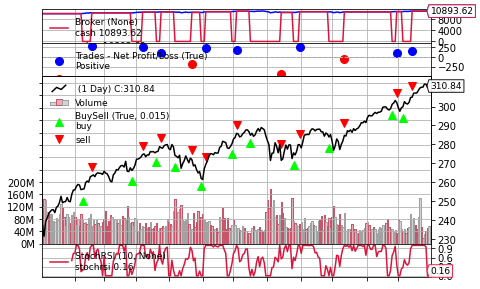

[[<Figure size 432x288 with 5 Axes>]]

In [90]:
cerebro.plot(iplot=False)